# Comparison of generalization capabilities of various optimization techniques in the context of deep networks

In [1]:
import torch
import torchvision
import ssl
import random
import numpy as np
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tqdm.notebook as tqdm
from torch.utils.data.sampler import SubsetRandomSampler
import os
# Custom helpers
from model import *
import nb_optimizers as opt
# Allow autoreload
%load_ext autoreload
%autoreload 2
# Allow Download of CIFAR datasets
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
print(device)

cuda:0


## Reproducibility

In [3]:
seed = 2022

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(seed)

## Download Datasets

In [4]:
CIFAR10_dataset_train = torchvision.datasets.CIFAR10("data/",download=True)
CIFAR10_dataset_test = torchvision.datasets.CIFAR10("data/",download=True,train=False)
###
CIFAR100_dataset_train = torchvision.datasets.CIFAR100("data/",download=True)
CIFAR100_dataset_test = torchvision.datasets.CIFAR100("data/",download=True,train=False)
###
MNIST_dataset_train = torchvision.datasets.MNIST("data/",download=True)
MNIST_dataset_test = torchvision.datasets.MNIST("data/",download=True,train=False)
##
FashionMNIST_dataset_train = torchvision.datasets.FashionMNIST("data/",download=True)
FashionMNIST_dataset_test = torchvision.datasets.FashionMNIST("data/",download=True,train=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Transforms

In [5]:
mean_per_channel_CIFAR10 = tuple((CIFAR10_dataset_train.data/255).mean(axis=(0,1,2)))
std_per_channel_CIFAR10 = tuple((CIFAR10_dataset_train.data/255).std(axis=(0,1,2)))
transform_CIFAR10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_per_channel_CIFAR10, std_per_channel_CIFAR10),
])

mean_per_channel_CIFAR100 = tuple((CIFAR10_dataset_train.data/255).mean(axis=(0,1,2))/255)
std_per_channel_CIFAR100 = tuple((CIFAR100_dataset_train.data/255).std(axis=(0,1,2)))
transform_CIFAR100 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_per_channel_CIFAR100, std_per_channel_CIFAR100),
])

mean_per_channel_MNIST = (MNIST_dataset_train.data.numpy()/255).mean()
std_per_channel_MNIST= (MNIST_dataset_train.data.numpy()/255).std()
transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_per_channel_MNIST, std_per_channel_MNIST),
])

mean_per_channel_FashionMNIST = (FashionMNIST_dataset_train.data.numpy()/255).mean()
std_per_channel_FashionMNIST = (FashionMNIST_dataset_train.data.numpy()/255).std()
transform_FashionMNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_per_channel_FashionMNIST, std_per_channel_FashionMNIST),
])

## Datasets

In [6]:
CIFAR10_dataset_train = torchvision.datasets.CIFAR10("data/",transform=transform_CIFAR10)
CIFAR10_dataset_test = torchvision.datasets.CIFAR10("data/",train=False,transform=transform_CIFAR10)
###
CIFAR100_dataset_train = torchvision.datasets.CIFAR100("data/",transform=transform_CIFAR100)
CIFAR100_dataset_test = torchvision.datasets.CIFAR100("data/",train=False,transform=transform_CIFAR100)
###
MNIST_dataset_train = torchvision.datasets.MNIST("data/",transform=transform_MNIST)
MNIST_dataset_test = torchvision.datasets.MNIST("data/",train=False,transform=transform_MNIST)
###
FashionMNIST_dataset_train = torchvision.datasets.FashionMNIST("data/",transform=transform_FashionMNIST)
FashionMNIST_dataset_test = torchvision.datasets.FashionMNIST("data/",train=False,transform=transform_FashionMNIST)

## Validation Split

In [7]:
def get_samplers(train_dataset,generator,shuffle=True,val_ratio=0.1):
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(val_ratio * num_train))
    if shuffle:
        np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx,generator=generator)
    val_sampler = SubsetRandomSampler(val_idx,generator=generator)
    return train_sampler, val_sampler

CIFAR10_train_sampler, CIFAR10_val_sampler = get_samplers(CIFAR10_dataset_train,g)
###
CIFAR100_train_sampler, CIFAR100_val_sampler = get_samplers(CIFAR100_dataset_train,g)
###
MNIST_train_sampler, MNIST_val_sampler = get_samplers(MNIST_dataset_train,g)
###
FashionMNIST_train_sampler, FashionMNIST_val_sampler = get_samplers(FashionMNIST_dataset_train,g)

## Dataloaders

In [8]:
batch_size = 1024
CIFAR10_dataloader_train = DataLoader(CIFAR10_dataset_train,batch_size=batch_size,pin_memory=True,
                                worker_init_fn=seed_worker, generator=g, sampler=CIFAR10_train_sampler,
                                     )
CIFAR10_dataloader_val = DataLoader(CIFAR10_dataset_train,batch_size=batch_size,pin_memory=True,
                                worker_init_fn=seed_worker, generator=g, sampler=CIFAR10_val_sampler,
                                     )
CIFAR10_dataloader_test = DataLoader(CIFAR10_dataset_test,batch_size=batch_size,pin_memory=True,
                                worker_init_fn=seed_worker, generator=g, shuffle=True)

---

In [9]:
CIFAR100_dataloader_train = DataLoader(CIFAR100_dataset_train,batch_size=batch_size,pin_memory=True,
                                worker_init_fn=seed_worker, generator=g, sampler=CIFAR100_train_sampler,
                                     )
CIFAR100_dataloader_val = DataLoader(CIFAR100_dataset_train,batch_size=batch_size,pin_memory=True,
                                worker_init_fn=seed_worker, generator=g, sampler=CIFAR100_val_sampler,
                                     )
CIFAR100_dataloader_test = DataLoader(CIFAR100_dataset_test,batch_size=batch_size,pin_memory=True,
                                worker_init_fn=seed_worker, generator=g, shuffle=True)

---

In [10]:
MNIST_dataloader_train = DataLoader(MNIST_dataset_train,batch_size=batch_size,pin_memory=True,
                                worker_init_fn=seed_worker, generator=g, sampler=MNIST_train_sampler,
                                     )
MNIST_dataloader_val = DataLoader(MNIST_dataset_train,batch_size=batch_size,pin_memory=True,
                                worker_init_fn=seed_worker, generator=g, sampler=MNIST_val_sampler,
                                     )
MNIST_dataloader_test = DataLoader(MNIST_dataset_test,batch_size=batch_size,pin_memory=True,
                                worker_init_fn=seed_worker, generator=g, shuffle=True)

---

In [11]:
FashionMNIST_dataloader_train = DataLoader(FashionMNIST_dataset_train,batch_size=batch_size,pin_memory=True,
                                worker_init_fn=seed_worker, generator=g, sampler=FashionMNIST_train_sampler,
                                     )
FashionMNIST_dataloader_val = DataLoader(FashionMNIST_dataset_train,batch_size=batch_size,pin_memory=True,
                                worker_init_fn=seed_worker, generator=g, sampler=FashionMNIST_val_sampler,
                                     )
FashionMNIST_dataloader_test = DataLoader(FashionMNIST_dataset_test,batch_size=batch_size,pin_memory=True,
                                worker_init_fn=seed_worker, generator=g, shuffle=True)

## EDA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([1024, 3, 32, 32])
Labels batch shape: torch.Size([1024])
Labels: 1


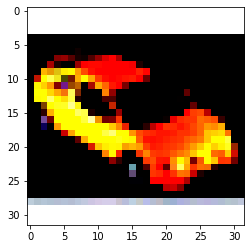

In [12]:
# Display image and label.
train_features, train_labels = next(iter(CIFAR10_dataloader_train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
if len(img.shape) > 2:
    img = np.swapaxes(img,0,-1)
    img = np.swapaxes(img,0,1)
#plt.imshow((img * 255).numpy().astype(np.uint8))
plt.imshow(img)
print(f"Labels: {label}")

## Model

In [13]:
model = VGG(3,10)
init_checkpoint = torch.load("init_models/CIFAR_10_2022.pth")
model.load_state_dict(init_checkpoint['model_state_dict'])
model.to(device)
if device.type == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

## Optimization

### Loss

In [15]:
criterion = nn.CrossEntropyLoss()

### Pytorch Optimizer

In [19]:
lr = 0.1
#optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), weight_decay=5e-4)

### Custom Optimizer

In [22]:
# change parameters of optimizers         
optimizer_params = {"learning_rate": 1e-1, "rho": 0.9, "tau": None, "delta": None, "beta1": None,
                            "beta2": None}
optimizer = opt.createOptimizer("momentumsgd", model.parameters(), optimizer_params)

### Scheduler

In [20]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

## Training

### Weight Collection

In [26]:
cnn_layer_weights = []
linear_layer_weights = []

def collect_weights(cnn_weights_list,linear_weights_list,model,channels_nb=3):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if m.in_channels == channels_nb:
                cnn_weights_list.append(m.weight.ravel().detach().cpu().numpy())
        elif isinstance(m, nn.Linear):
            linear_weights_list.append(m.weight.ravel().detach().cpu().numpy())

### Training Step

In [16]:
def train_step(model,train_dataloader,device,optimizer,criterion,epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    idx = 1
    for inputs, targets in tqdm.tqdm(train_dataloader,leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        ### Collect Weights
        if (idx%4) == 0:
            collect_first_layer_weights(first_layer_weights,model)
        ### Compute Accuracy
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        idx += 1
    print(f"At end of epoch {epoch} we have average loss {train_loss/total:.5f} and average accuracy {correct/total:.5f}%")

### Validation Step

In [17]:
def validation_step(model,val_dataloader,device,best_acc,epoch,checkpoint_name="checkpoint"):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm.tqdm(val_dataloader,leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    # Save checkpoint.
    accuracy = 100.*correct/total
    if accuracy > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'accuracy': accuracy,
            'epoch': epoch,
        }
        if not os.path.isdir(checkpoint_name):
            os.mkdir(checkpoint_name)
        torch.save(state, "./"+checkpoint_name+"/ckpt.pth")
        print(f"New optimal model at epoch {epoch} saved with validation accuracy {correct/total:.5f}%")
    else:
        print(f"Validation accuracy {correct/total:.5f}%")
    return accuracy

### Training Loop

In [18]:
max_epoch = 75
best_accuracy = -1
for epoch in tqdm.tqdm(range(max_epoch)):
    train_step(model,CIFAR10_dataloader_train,device,optimizer,criterion,epoch)
    epoch_accuracy = validation_step(model,CIFAR10_dataloader_val,device,best_accuracy,epoch,checkpoint_name="CIFAR10_lr_1e-1")
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 0 we have average loss 0.00183 and average accuracy 0.26393%


  0%|          | 0/5 [00:00<?, ?it/s]

Saving..
New optimal model at epoch 0 saved with validation accuracy 0.33620%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 1 we have average loss 0.00136 and average accuracy 0.47373%


  0%|          | 0/5 [00:00<?, ?it/s]

Saving..
New optimal model at epoch 1 saved with validation accuracy 0.53100%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 2 we have average loss 0.00103 and average accuracy 0.61551%


  0%|          | 0/5 [00:00<?, ?it/s]

Saving..
New optimal model at epoch 2 saved with validation accuracy 0.65460%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 3 we have average loss 0.00081 and average accuracy 0.70180%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.60140%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 4 we have average loss 0.00067 and average accuracy 0.75691%


  0%|          | 0/5 [00:00<?, ?it/s]

Saving..
New optimal model at epoch 4 saved with validation accuracy 0.72100%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 5 we have average loss 0.00056 and average accuracy 0.80176%


  0%|          | 0/5 [00:00<?, ?it/s]

Saving..
New optimal model at epoch 5 saved with validation accuracy 0.75400%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 6 we have average loss 0.00047 and average accuracy 0.83487%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.73100%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 7 we have average loss 0.00041 and average accuracy 0.85731%


  0%|          | 0/5 [00:00<?, ?it/s]

Saving..
New optimal model at epoch 7 saved with validation accuracy 0.78760%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 8 we have average loss 0.00034 and average accuracy 0.88236%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.74180%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 9 we have average loss 0.00029 and average accuracy 0.89776%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.78680%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 10 we have average loss 0.00025 and average accuracy 0.91393%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.66360%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 11 we have average loss 0.00022 and average accuracy 0.92213%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.77980%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 12 we have average loss 0.00018 and average accuracy 0.93740%


  0%|          | 0/5 [00:00<?, ?it/s]

Saving..
New optimal model at epoch 12 saved with validation accuracy 0.79580%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 13 we have average loss 0.00018 and average accuracy 0.93911%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.78500%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 14 we have average loss 0.00014 and average accuracy 0.95098%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.76100%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 15 we have average loss 0.00013 and average accuracy 0.95464%


  0%|          | 0/5 [00:00<?, ?it/s]

Saving..
New optimal model at epoch 15 saved with validation accuracy 0.82000%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 16 we have average loss 0.00013 and average accuracy 0.95664%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.80560%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 17 we have average loss 0.00010 and average accuracy 0.96344%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.77300%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 18 we have average loss 0.00011 and average accuracy 0.96218%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.79720%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 19 we have average loss 0.00010 and average accuracy 0.96622%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.77820%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 20 we have average loss 0.00008 and average accuracy 0.97120%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.81480%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 21 we have average loss 0.00008 and average accuracy 0.97367%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.81100%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 22 we have average loss 0.00009 and average accuracy 0.97011%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.81020%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 23 we have average loss 0.00007 and average accuracy 0.97464%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.76180%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 24 we have average loss 0.00007 and average accuracy 0.97536%


  0%|          | 0/5 [00:00<?, ?it/s]

Saving..
New optimal model at epoch 24 saved with validation accuracy 0.82800%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 25 we have average loss 0.00007 and average accuracy 0.97680%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.82200%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 26 we have average loss 0.00006 and average accuracy 0.97989%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.81220%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 27 we have average loss 0.00006 and average accuracy 0.97869%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.80240%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 28 we have average loss 0.00006 and average accuracy 0.97904%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.78920%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 29 we have average loss 0.00005 and average accuracy 0.98204%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.80060%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 30 we have average loss 0.00006 and average accuracy 0.98033%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.70460%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 31 we have average loss 0.00006 and average accuracy 0.98091%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.75720%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 32 we have average loss 0.00006 and average accuracy 0.97976%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.81200%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 33 we have average loss 0.00006 and average accuracy 0.98064%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.79600%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 34 we have average loss 0.00006 and average accuracy 0.98051%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.79920%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 35 we have average loss 0.00005 and average accuracy 0.98267%


  0%|          | 0/5 [00:00<?, ?it/s]

Saving..
New optimal model at epoch 35 saved with validation accuracy 0.83040%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 36 we have average loss 0.00004 and average accuracy 0.98616%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.81320%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 37 we have average loss 0.00005 and average accuracy 0.98293%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.80740%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 38 we have average loss 0.00006 and average accuracy 0.98133%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.81840%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 39 we have average loss 0.00006 and average accuracy 0.98142%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.83000%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 40 we have average loss 0.00005 and average accuracy 0.98376%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.82660%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 41 we have average loss 0.00005 and average accuracy 0.98238%


  0%|          | 0/5 [00:00<?, ?it/s]

Saving..
New optimal model at epoch 41 saved with validation accuracy 0.83300%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 42 we have average loss 0.00005 and average accuracy 0.98367%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.81060%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 43 we have average loss 0.00005 and average accuracy 0.98496%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.81580%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 44 we have average loss 0.00005 and average accuracy 0.98513%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.82880%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 45 we have average loss 0.00005 and average accuracy 0.98478%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.80740%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 46 we have average loss 0.00005 and average accuracy 0.98291%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.79920%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 47 we have average loss 0.00006 and average accuracy 0.98278%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.79220%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 48 we have average loss 0.00004 and average accuracy 0.98600%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.77560%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 49 we have average loss 0.00005 and average accuracy 0.98396%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.80820%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 50 we have average loss 0.00004 and average accuracy 0.98864%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.79980%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 51 we have average loss 0.00004 and average accuracy 0.98816%


  0%|          | 0/5 [00:00<?, ?it/s]

Saving..
New optimal model at epoch 51 saved with validation accuracy 0.83520%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 52 we have average loss 0.00003 and average accuracy 0.98891%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.79420%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 53 we have average loss 0.00005 and average accuracy 0.98347%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.83460%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 54 we have average loss 0.00006 and average accuracy 0.98171%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.79680%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 55 we have average loss 0.00006 and average accuracy 0.98211%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.82440%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 56 we have average loss 0.00004 and average accuracy 0.98573%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.80180%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 57 we have average loss 0.00004 and average accuracy 0.98613%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.82020%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 58 we have average loss 0.00004 and average accuracy 0.98811%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.73580%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 59 we have average loss 0.00004 and average accuracy 0.98824%


  0%|          | 0/5 [00:00<?, ?it/s]

Saving..
New optimal model at epoch 59 saved with validation accuracy 0.84200%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 60 we have average loss 0.00004 and average accuracy 0.98738%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.81380%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 61 we have average loss 0.00004 and average accuracy 0.98587%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.83540%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 62 we have average loss 0.00004 and average accuracy 0.98673%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.84200%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 63 we have average loss 0.00004 and average accuracy 0.98751%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.81160%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 64 we have average loss 0.00004 and average accuracy 0.98638%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.83660%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 65 we have average loss 0.00004 and average accuracy 0.98784%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.82500%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 66 we have average loss 0.00004 and average accuracy 0.98773%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.83620%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 67 we have average loss 0.00004 and average accuracy 0.98833%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.82660%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 68 we have average loss 0.00005 and average accuracy 0.98427%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.83200%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 69 we have average loss 0.00005 and average accuracy 0.98547%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.82920%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 70 we have average loss 0.00004 and average accuracy 0.98722%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.82420%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 71 we have average loss 0.00004 and average accuracy 0.98718%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.83140%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 72 we have average loss 0.00003 and average accuracy 0.98889%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.82980%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 73 we have average loss 0.00004 and average accuracy 0.98847%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.83580%


  0%|          | 0/44 [00:00<?, ?it/s]

At end of epoch 74 we have average loss 0.00003 and average accuracy 0.98924%


  0%|          | 0/5 [00:00<?, ?it/s]

Validation accuracy 0.77900%


## Weights Saving/Loading

In [37]:
def save_weights_for_viz(cnn_weights,linear_weights,basename):
    cnn_file = open(basename+"cnn_weights.npy","wb")
    linear_file = open(basename+"linear_weights.npy","wb")
    np.save(cnn_file,cnn_weights)
    np.save(linear_file,linear_weights)
    cnn_file.close()
    linear_file.close()

def load_weights_for_viz(basename):
    cnn_file = open(basename+"cnn_weights.npy","rb")
    linear_file = open(basename+"linear_weights.npy","rb")
    cnn_weights = np.load(cnn_file)
    linear_weights = np.load(linear_file)
    cnn_file.close()
    linear_file.close()
    return cnn_weights,linear_weights

## Weights Visualization

### PCA

In [19]:
weight_array = np.asarray(first_layer_weights)
weight_array.shape

(825, 1728)

In [20]:
pca = PCA(n_components=50,svd_solver="auto")

In [21]:
weight_pca = pca.fit(weight_array)

In [22]:
proj_weights = weight_pca.transform(weight_array)

### T-SNE

In [23]:
weights_embedded_2d = TSNE(n_components=2, learning_rate='auto',
                   init='pca').fit_transform(proj_weights)
weights_embedded_3d = TSNE(n_components=3, learning_rate='auto',
                   init='pca').fit_transform(proj_weights)

C:\Users\jerem\anaconda3\envs\opt_ml\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\jerem\anaconda3\envs\opt_ml\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


### Plot

### CIFAR10 SGD

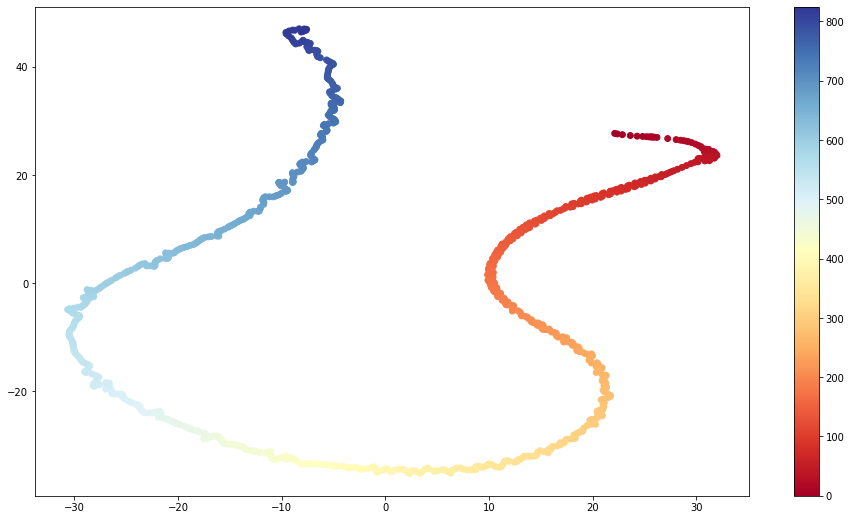

In [72]:
fig, ax = plt.subplots(figsize=(16,9))
cm = plt.cm.get_cmap('RdYlBu')
color_range = range(len(first_layer_weights))
sc = ax.scatter(weights_embedded_2d[:,0],weights_embedded_2d[:,1], c=color_range, vmin=0, vmax=len(first_layer_weights), s=35, cmap=cm)
plt.colorbar(sc)
plt.show()
#plt.scatter(weights_embedded[:,0],weights_embedded[:,1])

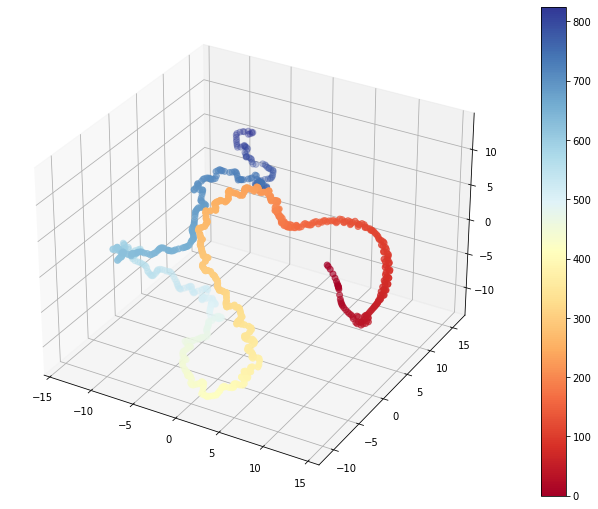

In [73]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cm = plt.cm.get_cmap('RdYlBu')
color_range = range(len(first_layer_weights))
sc = ax.scatter(weights_embedded_3d[:,0],weights_embedded_3d[:,1],weights_embedded_3d[:,2], c=color_range, vmin=0, vmax=len(first_layer_weights), s=35, cmap=cm)
plt.colorbar(sc)
plt.show()
#plt.scatter(weights_embedded[:,0],weights_embedded[:,1])

### CIFAR10 ADAM

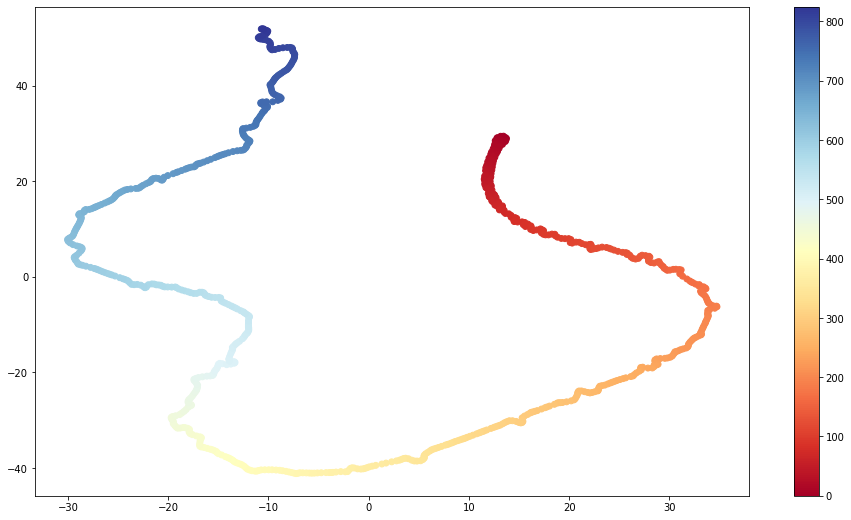

In [24]:
fig, ax = plt.subplots(figsize=(16,9))
cm = plt.cm.get_cmap('RdYlBu')
color_range = range(len(first_layer_weights))
sc = ax.scatter(weights_embedded_2d[:,0],weights_embedded_2d[:,1], c=color_range, vmin=0, vmax=len(first_layer_weights), s=35, cmap=cm)
plt.colorbar(sc)
plt.show()
#plt.scatter(weights_embedded[:,0],weights_embedded[:,1])

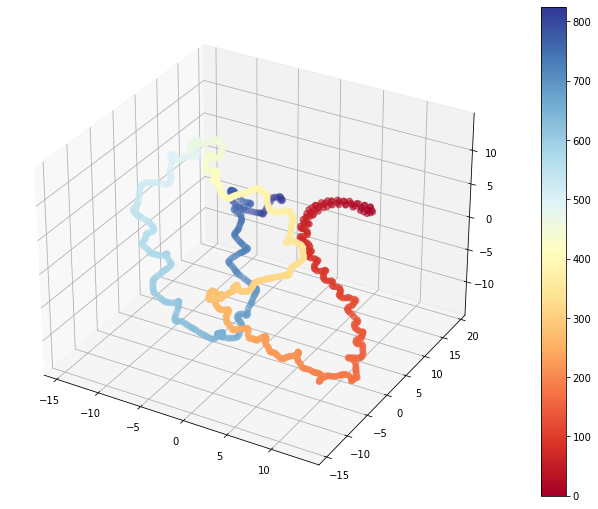

In [25]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cm = plt.cm.get_cmap('RdYlBu')
color_range = range(len(first_layer_weights))
sc = ax.scatter(weights_embedded_3d[:,0],weights_embedded_3d[:,1],weights_embedded_3d[:,2], c=color_range, vmin=0, vmax=len(first_layer_weights), s=35, cmap=cm)
plt.colorbar(sc)
plt.show()
#plt.scatter(weights_embedded[:,0],weights_embedded[:,1])

### Weight Counting

In [27]:
layers = []
total_parameters = 0
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        layers.append(m)
        total_parameters += m.weight.shape.numel()
print(total_parameters)

14710464


## Load Model

In [78]:
new_model = VGG(3,10)
new_state_dict = torch.load("CIFAR10_lr_1e-1/ckpt.pth")["model"]
formated_new_state_dict = dict()
for key, value in new_state_dict.items():
    formated_new_state_dict[key.split("module.")[-1]] = value
new_model.load_state_dict(formated_new_state_dict)

<All keys matched successfully>

## Check Accuracy

In [6]:
accuracy = torch.load("old/CIFAR100/CIFAR100_msgd_custom_lr_1e-1_rho_9e-1_ckpt.pth")["accuracy"]
accuracy

52.3

In [7]:
accuracy = torch.load("old/CIFAR100/CIFAR100_msgd_custom_lr_1e-2_rho_9e-1_ckpt.pth")["accuracy"]
accuracy

28.54

In [8]:
accuracy = torch.load("old/CIFAR100/CIFAR100_msgd_custom_lr_1e-3_rho_9e-1_ckpt.pth")["accuracy"]
accuracy

12.94

In [9]:
accuracy = torch.load("old/CIFAR100/CIFAR100_msgd_custom_lr_3e-2_rho_9e-1_ckpt.pth")["accuracy"]
accuracy

39.76

In [10]:
accuracy = torch.load("old/CIFAR100/CIFAR100_msgd_custom_lr_5e-1_rho_9e-1_ckpt.pth")["accuracy"]
accuracy

16.22

In [11]:
accuracy = torch.load("old/CIFAR100/CIFAR100_msgd_custom_lr_5e-2_rho_9e-1_ckpt.pth")["accuracy"]
accuracy

43.34

In [ ]:
accuracy = torch.load("bests/CIFAR100_MSGD/")["accuracy"]
accuracy

In [ ]:
2e-1 :  84.82 (sgd)

In [ ]:
2e-1 :  87.48 (msgd)
(3e-1 : 87.46) (msgd)

In [ ]:
# Fashion
93.717 (5e-1) (sgd)
93.983 (1e-1) (msgd)